# ML-2. Обучение с учителем: регрессия 

## Линейная регрессия: аналитическое решение

### Аналитическое решение линейной регрессии по МНК в Python

Этапы  
1. Загрузить данные. Проанализировать ДС
2. Подготовить данные для подачи в модель (пропуски, кат.признаки)
3. Построить модели
   1. Модель линейной регрессии на одном признаке
   2. Модель линейной регрессии на всех доступных признаках
4. Оценить качество модели

In [150]:
# импорт библиотек
import numpy as np                  #для матричных вычислений
import pandas as pd                 #для анализа и предобработки данных
import matplotlib.pyplot as plt     #для визуализации
import seaborn as sns               #для визуализации
%matplotlib inline
plt.style.use('seaborn')            #установка стиля matplotlib

Работаем с датасетом о домах в Бостоне из библиотеки sklearn  
Датасет содержится в модуле `datasets` библиотеки `sklearn`

In [238]:

# загружаем датасет
# from sklearn.datasets import load_boston      
# boston = load_boston()
# print(boston['DESCR'])                        # выводим описание датасета по ключу 'DESCR'
                                                # на момент выполнения курса датасет удален из библиотеки

# найденные ссылки на датасет
# http://lib.stat.cmu.edu/datasets/boston       # не получилось загрузить
# https://github.com/selva86/datasets/blob/master/BostonHousing.csv

boston_data = pd.read_html('https://github.com/selva86/datasets/blob/master/BostonHousing.csv')[0]
boston_data.drop(columns='Unnamed: 0', inplace=True)
display(boston_data.head())
display(boston_data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


(506, 14)

### Аналитическое решение с помощью numpy

Задача - научить модель предсказывать медианную стоимость дома на участке

<center> <img src = images/boston_data.png alt="drawing" style="width:800px;">

Чтобы прочитать датафрейм из библиотеки `sklearn` необходимо обратиться к ключу `data` следующим образом

In [152]:

# boston_data = pd.DataFrame(         # создаём DataFrame из загруженных numpy-матриц
#     data=boston.data,               # данные
#     columns=boston.feature_names    # наименования столбцов
# )

# boston_data['MEDV'] = boston.target # добавляем в таблицу столбец с целевой переменной
# boston_data.head()


In [153]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


**! ! !** Для модели линейной регрессии требуется, чтобы в подаваемых на вход данных не было пропущенных значений  
 
**! ! !** Не должно быть категориальных признаков

Строим столбчатую диаграмму для визуализации связи факторов с целевым признаком (`medv` - медианная цена)

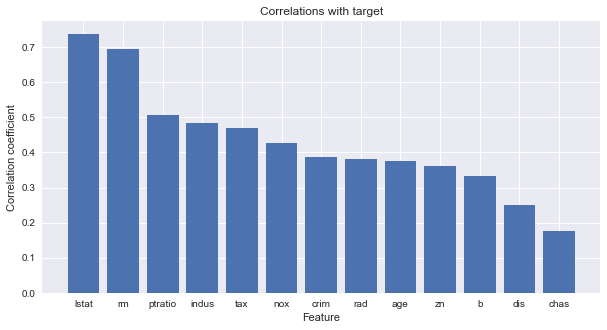

In [154]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['medv'].abs().sort_values(ascending=False)
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('medv')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5))                     # фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values)     # столбчатая диаграмма
ax.set_title('Correlations with target')                    # название графика
ax.set_xlabel('Feature')                                    # название оси x
ax.set_ylabel('Сorrelation coefficient');                   # название оси y

Строим линейную регрессию с наиболее коррелируемым признаком  

Построить линейную регрессию = обучить ЛР = найти параметры ЛР

In [155]:
X = boston_data[['lstat']]      # матрица наблюдений
y = boston_data['medv']         # вектор правильных ответов
X.head()

,lstat
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


**Двойные скобки** позволяют выбрать признак и сохранить его в виде таблицы  

В формуле МНК $X$ - это матрица


$$ w = (X^T X)^{-1}X^Ty = QX^Ty $$
$ X $ - Матрица примеров (наблюдений)  
$ y $ - Вектор правильных ответов к наблюдениям  
$ w $ - Вектор параметров (искомая величина)


Создаем функцию `linear_regression()`  

Функция  | Описание
------------- | -------------
`np.column_stack()`  |  - позволяет присоединить вектор к таблице
`np.linalg.inv()`  |  - вычисляет обратную матрицу
`@`  |  - матричное умножение
`T`  |  - транспонирование

In [156]:
def linear_regression(X, y):
    ones = np.ones(X.shape[0])      # Создаём вектор из единиц
    X = np.column_stack([ones, X])  # Добавляем вектор к таблице первым столбцом
    Q = np.linalg.inv(X.T @ X)      # Вычисляем обратную матрицу Q
    w = Q @ X.T @ y                 # Вычисляем вектор коэффициентов
    return w

In [157]:
w = linear_regression(X, y)         # Вычисляем параметры линейной регрессии
print('Vector w: {}'.format(w))     # Выводим вычисленные значения параметров в виде вектора
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))    # Выводим параметры с точностью до двух знаков после запятой


Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Модель будет иметь вид:  
$$ \hat{y} = 34.55 - 0.95x_{1} $$

Коэффициент $w_{0} = 34.55$ имитирует влияние сторонних факторов, которые не учтены в модели.  
Коэффициент $w_{1} = -0.95$ означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу.

In [158]:
x_example = 5.18                        # Задаём процент низкостатусного населения
y_predict = w[0] + w[1] * x_example     # Делаем предсказание
print('Predicted value: {:.2f}'.format(float(y_predict)))

Predicted value: 29.63


Визуализируем модель

In [159]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4))                          # фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data')           # диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model')  # линейный график
    ax.set_xlabel(xlabel)                                           # название оси абсцисс
    ax.set_ylabel(ylabel)                                           # название оси ординат
    ax.legend(facecolor='white', fontsize=11)                       # легенда

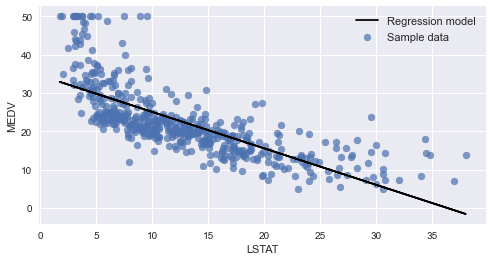

In [160]:
y_predict = w[0] + w[1] * X             # Делаем предсказание для всех объектов из таблицы
plot_regression_2d(X, y, y_predict)     # Строим визуализацию

### Аналитическое решение с помощью sklearn

In [161]:
from sklearn import linear_model        # из модуля нужен класс LinearRegression

класс - `LinearRegression`  
метод обучения модели - `fit()`  
метод предсказания по модели - `predict()`

In [162]:
lr_lstat = linear_model.LinearRegression()  # Создаём объект класса LinearRegression
lr_lstat.fit(X, y)                          # Обучаем модель — ищем параметры по МНК

print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_))      #остальные параметры модели w1, w2, ..., wm
 

w0: 34.55384087938311
w1: [-0.95004935]


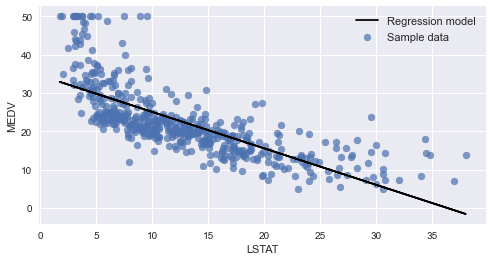

In [163]:
y_predict = lr_lstat.predict(X)             # Предсказываем медианную цену для всех участков из набора данных
plot_regression_2d(X, y, y_predict)         # Строим визуализацию

#### Линейная регрессия, используя все признаки

In [164]:
features = boston_data.drop('medv', axis=1).columns # Составляем список факторов (исключили целевой столбец)

X = boston_data[features]
y = boston_data['medv']                             # Составляем матрицу наблюдений X и вектор ответов y

lr_full = linear_model.LinearRegression()           # Создаём объект класса LinearRegression
lr_full.fit(X, y)                                   # Обучаем модель — ищем параметры по МНК

LinearRegression()

In [165]:
# Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
# Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,crim,-0.108011
1,zn,0.046420
2,indus,0.020559
3,chas,2.686734
4,nox,-17.766611
5,rm,3.809865
6,age,0.000692
7,dis,-1.475567
8,rad,0.306049
9,tax,-0.012335


Строим коробчатую диаграмму ошибок моделей.  
Ошибки считаем по формуле:
$$error_{i} = y_{i} - \hat{y_{i}}$$

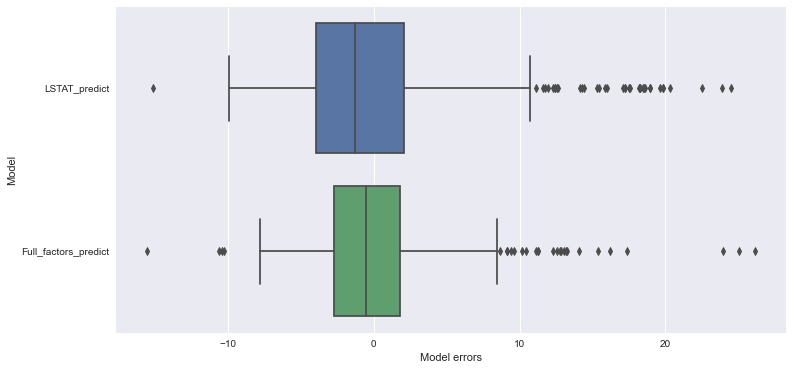

In [166]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6))     # фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['lstat']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Необходимо предсказать медианную стоимость для нового участка с параметрами

In [167]:
# копируем параметры
new_house = np.array([0.35114, 0.00000, 7.38000, 0.00000, 0.49300, 6.04100, 49.90000, 4.72110, 5.00000, 287.00000, 19.60000, 396.90000, 7.70000])
# создаем из заданных параметров датасет с одной строкой
new_house = pd.DataFrame([new_house], columns=features)
# применяем к элементу класса метод predict для предсказания стоимости
new_house_predict = lr_full.predict(new_house)

new_house_predict


array([22.86952447])

##### Расчет прибыли стартапов. Тренировка

In [168]:
# читаем датасет по ссылке
startup_data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/76e3de6d1b0566d70bcc348b7eb4ad47/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/50_Startups.zip')

In [169]:
startup_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [170]:
# отделяем факторы от целевой переменной
# в переменную передаем список с названием факторов
features2 = startup_data.drop(['Profit', 'State'], axis=1).columns
# создаем матрицу наблюдений
X = startup_data[features2]
# создаем вектор ответов
y1 = startup_data['Profit']
# обучаем модель методом наименьших квадратов с помощью библиотеки numpy
def linear_regression(X, y):
    ones = np.ones(X.shape[0])      # Создаём вектор из единиц
    X = np.column_stack([ones, X])  # Добавляем вектор к таблице первым столбцом
    Q = np.linalg.inv(X.T @ X)      # Вычисляем обратную матрицу Q
    w = Q @ X.T @ y                 # Вычисляем вектор коэффициентов
    return w

In [171]:
w = linear_regression(X, y1)         # Вычисляем параметры линейной регрессии
print('Vector w: {}'.format(w))     # Выводим вычисленные значения параметров в виде вектора
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))    # Выводим параметры с точностью до двух знаков после запятой
print('w2: {:.2f}'.format(w[2]))    # Выводим параметры с точностью до двух знаков после запятой
print('w3: {:.2f}'.format(w[3]))    # Выводим параметры с точностью до двух знаков после запятой

Vector w: [ 5.01221930e+04  8.05715050e-01 -2.68159684e-02  2.72280648e-02]
w0: 50122.19
w1: 0.81
w2: -0.03
w3: 0.03


## Метрики регрессии. Недостатки аналитического решения

### Расчет метрик на Python

In [172]:
from sklearn import metrics

In [173]:
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['lstat']])

mae = metrics.mean_absolute_error(y, y_predict_lstat)
rmse = np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))
mape = metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100
r2 = metrics.r2_score(y, y_predict_lstat)

print(f'MAE: {round(mae, 3)}')
print(f'RMSE: {round(rmse, 3)}')
print(f'MAPE: {round(mape, 3)}')
print(f'R2: {round(r2, 3)}')

MAE: 4.505
RMSE: 6.203
MAPE: 21.352
R2: 0.544


In [174]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])

mae = metrics.mean_absolute_error(y, y_predict_full)
rmse = np.sqrt(metrics.mean_squared_error(y, y_predict_full))
mape = metrics.mean_absolute_percentage_error(y, y_predict_full) * 100
r2 = metrics.r2_score(y, y_predict_full)

print(f'MAE: {round(mae, 3)}')
print(f'RMSE: {round(rmse, 3)}')
print(f'MAPE: {round(mape, 3)}')
print(f'R2: {round(r2, 3)}')

MAE: 3.271
RMSE: 4.679
MAPE: 16.417
R2: 0.741


Тренировка

In [175]:
# нужно найти RMSE
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
rmse

5.746042116100439

In [176]:
# нужно найти коэф детерминации
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]
r2 = metrics.r2_score(y_true, y_pred)
r2

0.707747874730212

## Линейная регрессия: численное решение

In [177]:
# датасет уже загружен ранее
boston_data.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


#### Обучение модели с помощью градиентного спуска

Обучаем на одном факторе

In [178]:
X = boston_data[['lstat']]      # матрица наблюдений
y = boston_data['medv']         # вектор правильных ответов

`sklearn`             - биюлиотека  
`linear_model`        - модуль  
`SGDRegressor`        - класс СГС для линейной регрессии  
`sklearn.linear_model.SGDRegressor`

In [179]:
# создаем объект калсса линейной регрессии SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)
# обучаем модель, ищем по SGD
sgd_lr_lstat.fit(X, y)

SGDRegressor(random_state=42)

Аттрибуты:

`coef_` - остальные параметры модели w1, w2, ...,  
`intercept_` - свободный член w0

In [180]:
print(f'w0: {sgd_lr_lstat.intercept_}')
print(f'w1: {sgd_lr_lstat.coef_}')

w0: [34.33010969]
w1: [-0.96193242]


Предсказываем цену. Визуализируем

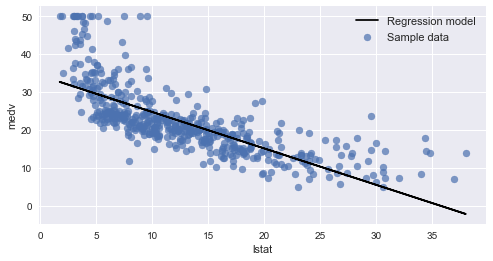

In [181]:
# функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='lstat', ylabel='medv'):
    fig, ax = plt.subplots(figsize=(8, 4)) # фигура + коорд плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') # диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') # лин график
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(facecolor='white', fontsize=11)

# предсказываем медианную цену для всех участков набора данных
y_predict = sgd_lr_lstat.predict(X)
plot_regression_2d(X, y, y_predict)

Можно расчитать метрики регрессии

In [182]:
r2 = metrics.r2_score(y, y_predict)
mae = metrics.mean_absolute_error(y, y_predict)
mape = metrics.mean_absolute_percentage_error(y, y_predict) * 100
rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print(f'R2: {round(r2, 3)}')
print(f'MAE: {round(mae, 3)}')
print(f'MAPE: {round(mape, 3)}')
print(f'RMSE: {round(rmse, 3)}')

R2: 0.542
MAE: 4.431
MAPE: 20.79
RMSE: 6.215


Обучаем многомерную модель

In [183]:
# составляем список факторов за исключением целевого
features = boston_data.drop('medv', axis=1).columns
X = boston_data[features]   # матрица наблюдений
y = boston_data[['medv']]   # вектор правильных ответов
# создаем объект класса линейно регрессии SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
sgd_lr_full.fit(X, y)       # обучаем модель
# составляем таблицу из признаоков и их коэффициетов
w_df = pd.DataFrame({'Features': features, 'Coeffs': sgd_lr_full.coef_})
# Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coeffs': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)


d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,Features,Coeffs
0,crim,2.156857e+11
1,zn,1.248446e+10
2,indus,7.277644e+09
3,chas,8.306154e+09
4,nox,-8.413828e+09
5,rm,-3.148182e+10
6,age,8.685820e+10
7,dis,-2.256141e+11
8,rad,-4.683208e+10
9,tax,1.892286e+09


In [184]:
# предсказываем медианную цену
y_predict = sgd_lr_full.predict(X)
# расчитываем коэффициент детерминации
r2 = metrics.r2_score(y, y_predict)
r2

-1.0590303862129977e+25

Необходимо стандартизировать данные

In [185]:
from sklearn import preprocessing

# инициализируем стандартизатор 
scaler = preprocessing.StandardScaler()
# производим стандартизацию
X_scaled = scaler.fit_transform(X)
# составляем дф из результата
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


Попытка 2. С учетом стандартизации

In [186]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)
#Обучаем модель — ищем параметры по методу SGD
#Подаём стандартизованные данные
sgd_lr_full.fit(X_scaled, y)
 
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': sgd_lr_full.coef_})
#Составляем строчку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': sgd_lr_full.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)


d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,Features,Coefficients
0,crim,-0.870552
1,zn,0.947112
2,indus,-0.116802
3,chas,0.730289
4,nox,-1.894276
5,rm,2.757578
6,age,-0.027846
7,dis,-3.049237
8,rad,1.957066
9,tax,-1.305271


In [187]:
# Предсказываем медианную цену для всех участков из набора данных
# Передаём стандартизованные данные
y_predict = sgd_lr_full.predict(X_scaled)
# расчитываем коэффициент детерминации
print(f'{metrics.r2_score(y, y_predict)}')

0.7396256329371903


Модификации SGDRegressor:  
`learning_rate = 'invscaling` - режим уменьшает темп обучения по формуле  
`learning_rate = 'constant` - параметр темпа обучения сохранится на всем протяжении операции  
`eta0 = 0.01` - начальное значение темпа обучения

In [189]:
# создаем объект класса линейной регрессии SGD
sgd_rl_bad = linear_model.SGDRegressor(
    learning_rate='constant',   # режим темпа обучения
    eta0=0.1,                   # начальное и постоянное значение темпа обучения
    random_state=42
)
# обучаем модель
sgd_rl_bad.fit(X_scaled, y)     # подаем стандартизованные данные
y_predict = sgd_rl_bad.predict(X_scaled)    # предсказываем цену
print(f'{metrics.r2_score(y, y_predict)}')

-335415038359.6347


d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Поставим слишком маленькое значение темпа обучения

In [190]:
sgd_lr_bad2 = linear_model.SGDRegressor(
    learning_rate='constant',
    eta0=1e-6,
    random_state=42
)
# обучаем
sgd_lr_bad2.fit(X_scaled, y)
# предсказываем
y_predict = sgd_lr_bad2.predict(X_scaled)
# рассчитываем R2
print(f'{metrics.r2_score(y, y_predict)}')

-1.5780839271041764


d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Изменим значение критерия остановки

In [192]:
# создаем объект класса
sgd_lr_train = linear_model.SGDRegressor(
    tol=0.1, # критерий остановки
    random_state=42
)
# обучаем
sgd_lr_train.fit(X_scaled, y)
# предсказываем
y_predict = sgd_lr_train.predict(X_scaled)
# расчитываем коэф детерминации R2
print(f'{metrics.r2_score(y, y_predict)}')



0.7354496342878896


d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Смещение и разброс. Полиномиальные признаки. Регуляризация

### Разделение набора данных на тестовый и обучающий

Работаем с домами Бостона

In [239]:
# составляем список факторов, исключаем целевой столбец
features = boston_data.drop('medv', axis=1).columns
X = boston_data[features]   # матрица наблюдений
y = boston_data['medv']     # вектор ответов

`model_selection` - модуль  
`train_test_split()` - функция  

передаем:  
`X, y` - таблица с примерами и ответами  
`random_state`  
`test_size`  

Возвращает:  
- тренировочные примеры  
- тестовые примеры  
- тренировочные ответы  
- тестовые ответы


In [240]:
from sklearn.model_selection import train_test_split
# разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
# выводим результирующие размеры
print(f'Train {X_train.shape, y_train.shape}')
print(f'Train {X_test.shape, y_test.shape}')


Train ((354, 13), (354,))
Train ((152, 13), (152,))


Обучим линейную регрессию на тренировочных данных

In [241]:
# создаем обхект класса LinearRegression
lr_model = linear_model.LinearRegression()
# обучаем модель по МНК
lr_model.fit(X_train, y_train)

# предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
# для тестовой выборки
y_test_predict = lr_model.predict(X_test)

print(f'Train R2: {metrics.r2_score(y_train, y_train_predict)}')
print(f'Test R2: {metrics.r2_score(y_test, y_test_predict)}')

Train R2: 0.7434997532004697
Test R2: 0.7112260057484894


## Полиномиальные признаки

In [242]:
# создаем генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)

# генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
# генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)

# выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(354, 104)
(152, 104)


В результате получены numpy массивы. Теперь загружаем наши данные в модель линейно регрессии, для того, чтобы найти коэф-ты полинома по МНК-алгоритму

In [243]:
# создаем объект класса 
lr_model_poly = linear_model.LinearRegression()
# обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
# предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
# предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)

# расчитываем коэфф детерминации для трэйна и для теста
print(f'{metrics.r2_score(y_train, y_train_predict_poly)}')
print(f'{metrics.r2_score(y_test, y_test_predict_poly)}')

0.9469794920108194
0.6610321969508431


### Регуляризация

Стандартизацию проводим перед генерацией полиномиальных признаков

Предобработка данных

In [244]:
# инициализируем стандартизатор StandardScaler()
scaler = preprocessing.StandardScaler()
# подгоняем параметры стандартизатора
scaler.fit(X_train)
# производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
# производим стандартизацию тестовой выборки
X_test_scaled =  scaler.transform(X_test)

# создаем генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
# генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(354, 104)
(152, 104)


Методы регуляризации:  
`sklearn` - библиотека  
`Lasso` - класс L1 регуляризации  
`Ridge` - класс L2 регуляризации  

Строим модель линейно регрессии с L1-регуляризацией на сгенерированных полиномиальных признаках

In [245]:
# создаем объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1) # по умолчанию альфа = 1
# обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
# делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
# делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

# расчитывем коээфициент детерминации
print(f'Train R2: {metrics.r2_score(y_train, y_train_predict_poly)}')
print(f'Test R2: {metrics.r2_score(y_test, y_test_predict_poly)}')

Train R2: 0.9070657101514069
Test R2: 0.8055776105496002


In [246]:
print(np.round(lasso_lr_poly.coef_, 2))

[-0.   -0.   -0.    0.   -0.    3.39 -0.75 -0.84  0.   -0.24 -1.16  0.
 -4.   -0.01  0.   -0.    2.73 -0.    0.34  0.    0.   -0.06 -0.   -0.
  0.   -0.    0.1   0.    0.    0.    0.    0.    0.   -0.    0.    0.23
 -0.   -0.    0.16  0.    0.    0.    0.    0.    0.    0.   -0.08 -0.
 -0.44  0.38 -0.62 -0.56  0.05 -0.    0.    0.09 -0.    0.   -0.53 -0.52
 -0.45 -0.    0.   -0.   -0.   -0.25 -0.05  0.    0.47 -0.44  0.   -1.75
 -0.   -0.83 -0.16 -0.    0.    0.    0.49  0.31 -0.   -0.05 -0.59  0.
  0.   -0.    0.12 -0.    0.23 -0.    0.    0.   -0.   -1.53  0.41  0.11
 -0.05 -0.56 -0.   -0.    0.   -0.19 -0.    1.3 ]


На тех же данных обучаем модель линейно регрессии с L2-регуляризацией.

In [247]:
# создаем объект класса линейной регресии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=50)
# обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
# делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

# расчитываем коэффициент детерминации
print(f'Train R2: {metrics.r2_score(y_train, y_train_predict_poly)}')
print(f'Test R2: {metrics.r2_score(y_test, y_test_predict_poly)}')

Train R2: 0.9085426418396865
Test R2: 0.8229843225141729


In [248]:
# выводим коэффициенты модели
print(np.round(ridge_lr_poly.coef_, 2))

[-0.16  0.1  -0.23  0.08 -0.45  2.97 -0.66 -0.68  0.33 -0.58 -0.85  0.41
 -2.73  0.06  0.04  0.01  0.82 -0.2   0.44  0.12  0.33 -0.43 -0.    0.08
 -0.03  0.    0.23 -0.    0.23  0.2   0.02 -0.05 -0.11 -0.1   0.14  0.14
 -0.02 -0.02  0.46  0.15  0.13  0.1   0.53  0.33  0.05  0.11 -0.36  0.1
 -0.59  0.25 -0.91 -0.6   0.24 -0.39  0.33  0.56 -0.    0.2  -0.51 -0.47
 -0.63  0.01  0.45 -0.39 -0.03 -0.23 -0.28  0.27  0.53 -0.52  0.04 -0.97
 -0.7  -0.98 -0.23 -0.23  0.15  0.03  0.45  0.37 -0.08 -0.3  -0.82  0.35
  0.11 -0.03  0.19 -0.29  0.62 -0.32  0.37  0.48 -0.1  -0.84  0.25  0.52
 -0.21 -0.87 -0.1  -0.11  0.09 -0.28 -0.18  0.74]


Не очень удобно перебирать альфу в ручную  
Организуем список, в котором будем перебирать различные значения альфы, с помощью `linspace()`.

In [249]:
# создаем список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
# пустые списки для результатов
train_scores = []
test_scores = []

for alpha in alpha_list:
    # создаем объект класса лин регрессии L1
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000, random_state=42)
    # обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    # делаем предсказание
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    # расчитываем коэфф детерминации, добавляем в список
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))
    

d:\Users\dolzh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9419814411003244, tolerance: 3.111537141242938
  model = cd_fast.enet_coordinate_descent(


Построим графики изменения метрики

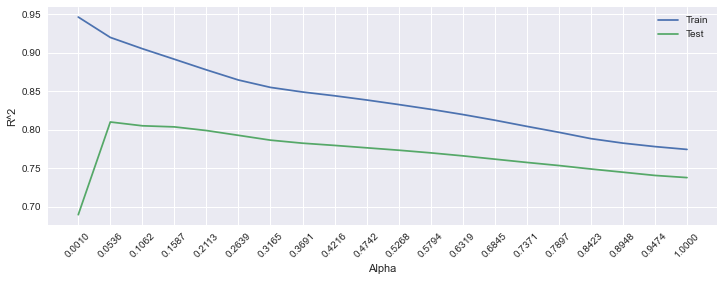

In [250]:
# визуализируем изменение метрики в зависимости от альфа
fig, ax = plt.subplots(figsize=(12, 4))     # фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train')
ax.plot(alpha_list, test_scores, label='Test')

ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

Исходя из графика подставляем значение альфа=0.0536

In [237]:
lasso_lr_poly = linear_model.Lasso(alpha=0.0536) # объект класса
lasso_lr_poly.fit(X_train_scaled_poly, y_train) # обучаем
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly) # предсказываем трейн
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly) # предсказываем тест
# коэф детерминации
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.920
Test R^2: 0.810
